# Libraries

In [57]:
#the usual
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt

#for FFT
import scipy
#for Signal Processing
import pywt

# Useful Functions

### Dealing With CSV

In [58]:
def remove_blank_lines(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    # Remove blank lines
    lines = [line for line in lines if line.strip()]
    
    with open(file_path, 'w', newline='') as file:
        file.writelines(lines)

### Data Viz

In [2]:
def plot_axes_vertical(df1,df2,time,para1,para2,para3,name1='Data1',name2='Data2'):
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    plt.rcParams['axes.grid'] = True
    axs[0].plot(df1[time][:], df1[para1][:], label=name1, color='blue')
    axs[0].plot(df2[time][:], df2[para1][:], label=name2,color='red')
    axs[0].set_ylabel(para1)
    axs[1].plot(df1[time][:], df1[para2][:], label=name1, color='blue')
    axs[1].plot(df2[time][:], df2[para2][:], label=name2, color='red')
    axs[1].set_ylabel(para2)
    axs[2].plot(df1[time][:], df1[para3][:], label=name1, color='blue')
    axs[2].plot(df2[time][:], df2[para3][:], label=name2, color='red')
    axs[2].set_ylabel(para3)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')

In [3]:
def compare_plot_inrange(df1,df2,time,para1,para2,minrange,maxrange,name1='Data1',name2='Data2'):
    plt.plot(df1[time][minrange:maxrange], df1[para1][minrange:maxrange], label=name1, color='green')
    plt.plot(df2[time][minrange:maxrange], df2[para2][minrange:maxrange], label=name2, color='red')
    plt.xlabel(time)
    if para1 == para2:
        plt.ylabel(para1)
    else:
        plt.ylabel(para1 + ' and ' + para2)
    plt.legend()

### Signal Processing

In [4]:
#Denosing the data in a dataframe using wavelet transform, the last 3 levels of the wavelet transform are set to zero to remove noise
def denoise_dataframe(df):
    newdf = pd.DataFrame()
    newdf.insert(len(newdf.columns), 'PacketCounter', df['PacketCounter'] ) 
    newdf.insert(len(newdf.columns), 'SampleTimeFine', df['SampleTimeFine'] ) 
    #newdf['SampleTimeFine'] = df['SampleTimeFine']
    wavelet = 'db4'
    columns_to_exclude = ['PacketCounter', 'SampleTimeFine','Unnamed: 11']
    for column in df.columns:
        if column not in columns_to_exclude:
            FPData = np.array(df[column]).astype('float32')
            DWTcoeffs = pywt.wavedec(FPData[:], wavelet)
            DWTcoeffs[-1] = np.zeros_like(DWTcoeffs[-1])
            DWTcoeffs[-2] = np.zeros_like(DWTcoeffs[-2]) 
            DWTcoeffs[-3] = np.zeros_like(DWTcoeffs[-3])
            #DWTcoeffs[-4] = np.zeros_like(DWTcoeffs[-4])
            #DWTcoeffs[-5] = np.zeros_like(DWTcoeffs[-5])
            FPData_Decompos=pywt.waverec(DWTcoeffs,wavelet,mode='symmetric',axis=-1)
            if (len(FPData_Decompos) != len(FPData)):
                #print('Length of the decomposed signal is not equal to the original signal')
                FPData_Decompos = FPData_Decompos[0:len(FPData)]
            newdf.insert( len(newdf.columns),column, FPData_Decompos )
    return newdf

In [5]:
#Remove DC Component of the Signal
# DC Component is the average of the signal over the time period, DC component in this case means there is a constant value added to the signal being 
# constant acceleration.
def remove_dc_component(df):
    columns_to_exclude = ['PacketCounter', 'SampleTimeFine','Euler Z','Euler Y','Euler X']
    for column in df.columns:
        if column not in columns_to_exclude:
            df[column] = df[column] - df[column].mean()
    return df

In [6]:
#FFT:Given a dataframe column, N being Sample Rate, F being Frequency of the signal, threshold being the threshold to ignore freq. below it for the FFT, and the plot_range to plot the FFT
#Compute FFT of the data and plot it
def plot_fft(df,N=1000,F=800,threshold=200,plot_range=1000):
    # sample spacing
    T = 1.0 / F
    x = np.linspace(0.0, N*T, N)
    y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
    yf = scipy.fftpack.fft(df.values)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    for i, value in enumerate(yf):
        if np.abs(value) < threshold:
            yf[i] = 0
    fig, ax = plt.subplots()
    ax.plot(xf[:plot_range], 2.0/N * np.abs(yf[:N//2])[:plot_range])
    plt.show()

In [7]:
def Compute_Velo(dfprime,paratobeadded,para2,sampling_rate=60):
    print("Computing " + paratobeadded + " based on " + para2)
    if paratobeadded not in dfprime.columns:
        dfprime.insert( len(dfprime.columns), paratobeadded,0)
        #dfprime[0,paratobeadded] = 0
        for i in range(1,len(dfprime[para2])):
            # Vn = Vn-1 + An * (1/sampling_rate) assuming V0 = 0 and A0 = 0
            (dfprime.loc[i,paratobeadded]) = round( dfprime[paratobeadded][i-1] + dfprime[para2][i]*(1/sampling_rate) ,6 )

In [8]:
mydict = {'Velo_X':'Acc_X','Velo_Y':'Acc_Y','Velo_Z':'Acc_Z','ANG_X':'Gyr_X','ANG_Y':'Gyr_Y','ANG_Z':'Gyr_Z'}
velolist = ['Velo_X','Velo_Y','Velo_Z','ANG_X','ANG_Y','ANG_Z']
def Compute_All_Velo(df,sampling_rate=60):
    newdf = pd.DataFrame()
    newdf = df
    for item in velolist:
        if item not in newdf.columns:
            Compute_Velo(newdf,item,mydict[item],sampling_rate)
    return newdf

## COMBINE EVERYTHING FUNCTION

In [31]:
import os
def read_all_csv_files_with_processing(mydirectory,savedir,save=False,removedc = False,denoise = False):
    mydf = {}
    for filename in os.listdir(mydirectory):
        if filename.endswith('.csv'):
            myname = filename.split('_')[0:1]
            file_path = os.path.join(mydirectory, filename)
            print("Reading File: " + filename)
            remove_blank_lines(file_path)
            df = pd.read_table(file_path,sep=',',skip_blank_lines=True,na_filter=True)
            df = df.dropna()
            if "Unnamed: 11" in df.columns:
                df.drop("Unnamed: 11", axis=1, inplace=True)
            if denoise:
                df = denoise_dataframe(df)
            if removedc:
                df = remove_dc_component(df)
            print("Will Start Computing Velocities for " + myname[0])
            df = Compute_All_Velo(df,sampling_rate=60)
            if save:
                print("Saving the File with Updated Velocities")
                if not os.path.exists(savedir):
                    os.makedirs(savedir)
                df.to_csv(savedir +  "\\" + myname[0] + " with all velo" + ".csv", index=None, header=True)
            mydf[ myname[0] ] = df
    print (mydf.keys())
    return mydf

# Analysis

## Directory

In [59]:
mydirectory = r'.\data\new'
savedir = os.path.join(mydirectory,'Processed')
savedir2 = os.path.join(mydirectory,'NOTPro')

## Velocity

In [60]:
mydf = read_all_csv_files_with_processing(mydirectory,savedir,denoise=True,removedc=True,save=True)
mydf.keys()

Reading File: Head2_D422CD00742D_20240312_120949.csv
Will Start Computing Velocities for Head2
Computing Velo_X based on Acc_X
Computing Velo_Y based on Acc_Y
Computing Velo_Z based on Acc_Z
Computing ANG_X based on Gyr_X
Computing ANG_Y based on Gyr_Y
Computing ANG_Z based on Gyr_Z
Saving the File with Updated Velocities
Reading File: Head_D422CD008B5C_20240312_120949.csv
Will Start Computing Velocities for Head
Computing Velo_X based on Acc_X
Computing Velo_Y based on Acc_Y
Computing Velo_Z based on Acc_Z
Computing ANG_X based on Gyr_X
Computing ANG_Y based on Gyr_Y
Computing ANG_Z based on Gyr_Z
Saving the File with Updated Velocities
Reading File: Left Foot2_D422CD0092B4_20240312_120949.csv
Will Start Computing Velocities for Left Foot2
Computing Velo_X based on Acc_X
Computing Velo_Y based on Acc_Y
Computing Velo_Z based on Acc_Z
Computing ANG_X based on Gyr_X
Computing ANG_Y based on Gyr_Y
Computing ANG_Z based on Gyr_Z
Saving the File with Updated Velocities
Reading File: Left F

dict_keys(['Head2', 'Head', 'Left Foot2', 'Left Foot', 'Left Hand2', 'Left Hand', 'Right Foot2', 'Right Foot', 'Right Hand2', 'Right Hand'])

In [61]:
df = mydf['Head']
df2 = mydf['Right Hand']
df3 = mydf['Left Hand']
df4 = mydf['Right Foot']    
df5 = mydf['Left Foot']

sdf = mydf['Head2']
sdf2 = mydf['Right Hand2']
sdf3 = mydf['Left Hand2']
sdf4 = mydf['Right Foot2']    
sdf5 = mydf['Left Foot2']

## Plots

In [67]:
df['Velo_Z'].mean()

-2.312552477795786

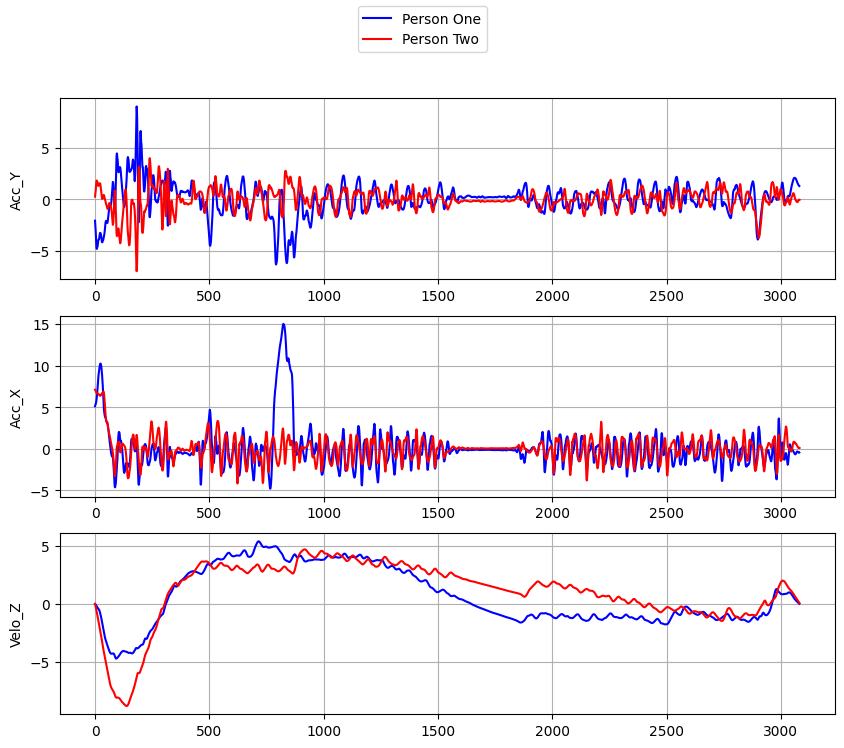

In [68]:
plot_axes_vertical(df2,df3,'PacketCounter','Acc_Y','Acc_X','Velo_Z',name1='Person One',name2='Person Two')


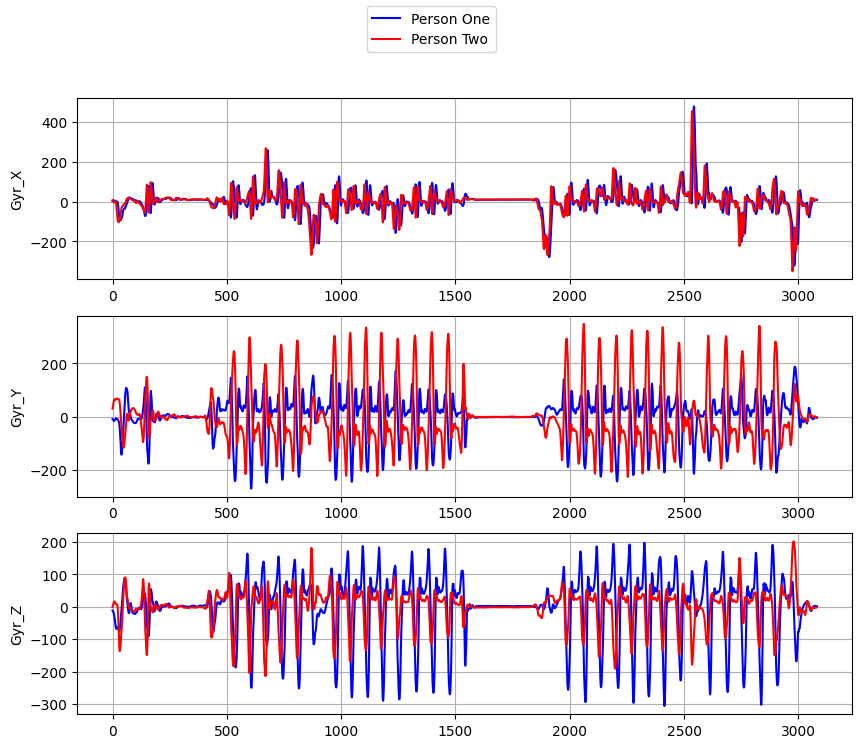

In [69]:
plot_axes_vertical(sdf4,df4,'PacketCounter','Gyr_X','Gyr_Y','Gyr_Z',name1='Person One',name2='Person Two')

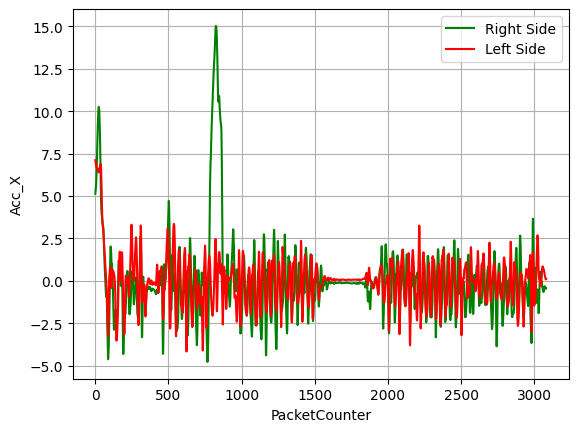

In [73]:
compare_plot_inrange(df2,df3,'PacketCounter','Acc_X','Acc_X',0,5000,name1='Right Side',name2='Left Side')

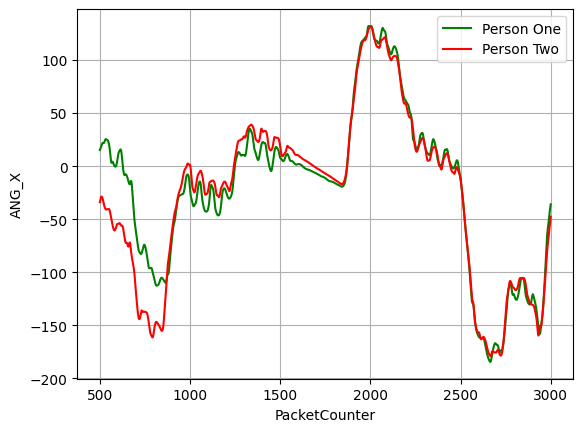

In [75]:
compare_plot_inrange(df2,df3,'PacketCounter','ANG_X','ANG_X',500,3000,name1='Person One',name2='Person Two')

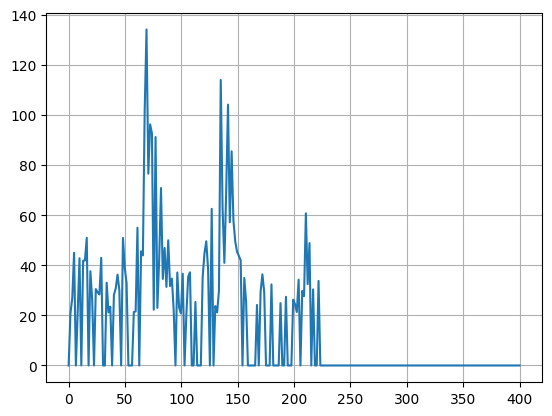

In [76]:
test = df4['Gyr_Z']- df4['Gyr_Z'].mean()
plot_fft( test ,N=500,F=800,threshold=5000,plot_range=1000)

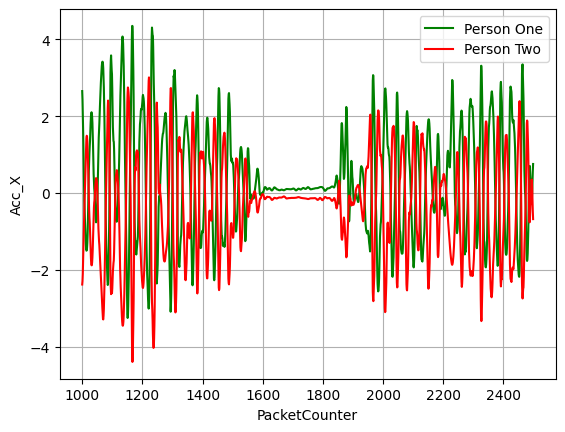

In [77]:
compare_plot_inrange(sdf2,df2,'PacketCounter','Acc_X','Acc_X',1000,2500,name1='Person One',name2='Person Two')

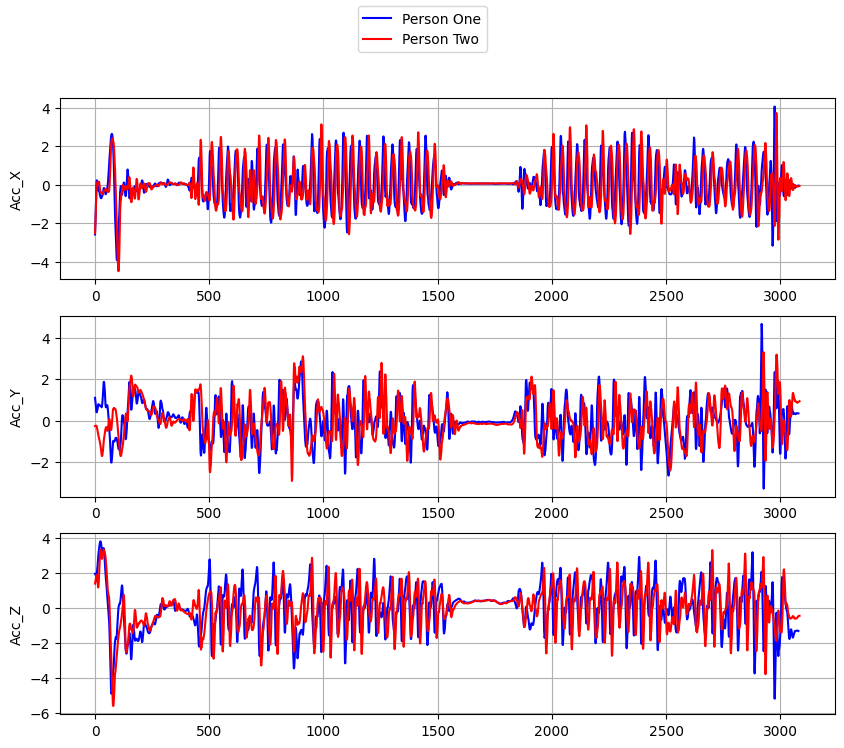

In [79]:
plot_axes_vertical(sdf,df,'PacketCounter','Acc_X','Acc_Y','Acc_Z',name1='Person One',name2='Person Two')

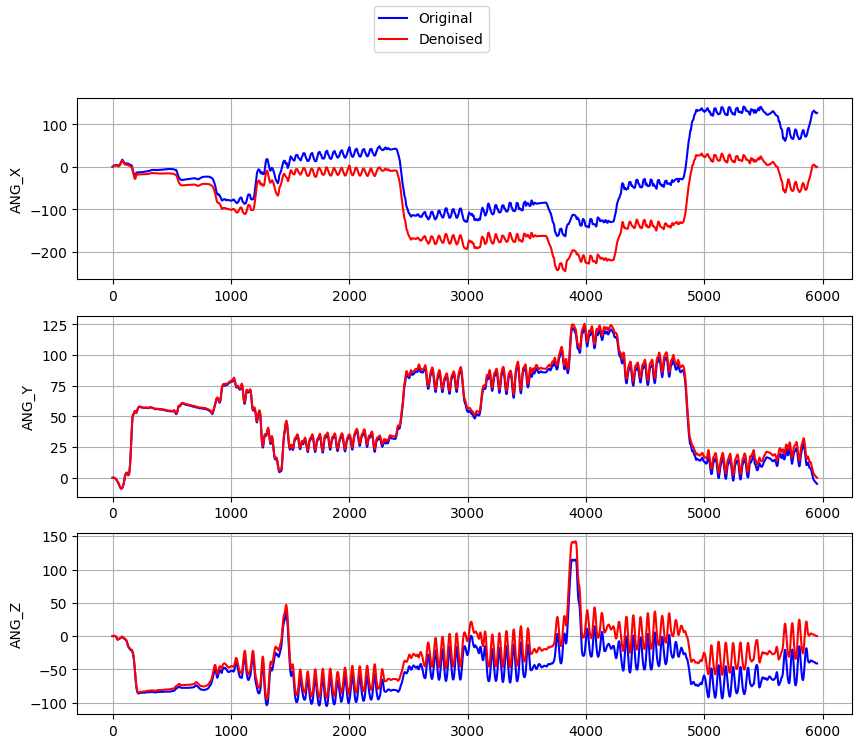

In [25]:
plot_axes_vertical(sdf2,df2,'PacketCounter','ANG_X','ANG_Y','ANG_Z',name1='Original',name2='Denoised')

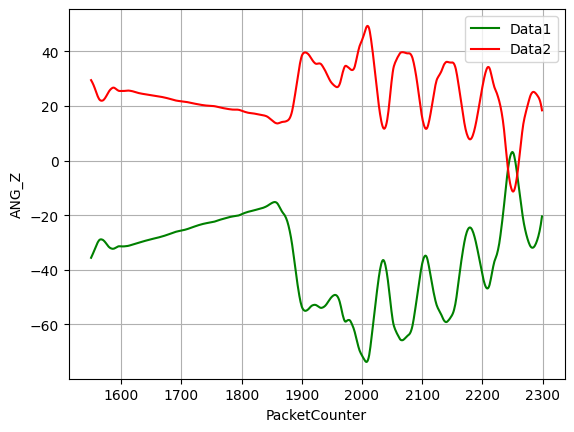

In [80]:
compare_plot_inrange(sdf2,df2,'PacketCounter','ANG_Z','ANG_Z',1550,2300)

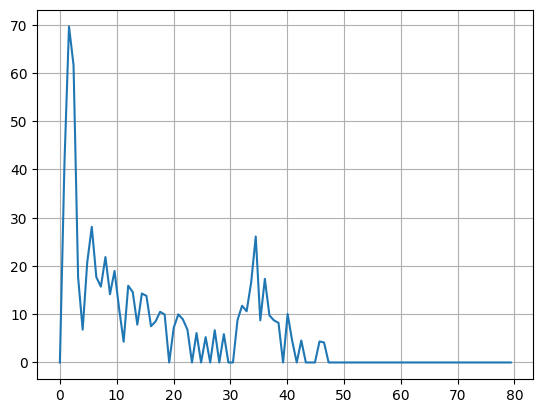

In [81]:
test = df2['ANG_Z']- df2['ANG_Z'].mean()
plot_fft(test,N=1000,F=800,threshold=2000,plot_range=100)